# *"Making science faster and more accurate"*

### or

# Accelerating Gaussian Process Regression with `pytorch` and GPUs

by Michael Gully-Santiago, PhD

Saturday, October 14 - Sunday, October 15, 2017  
GitHub HQ, San Francisco, CA USA  

**The scientific process can often be boiled down to fitting a model to data.**  The parameters of the model can represent physical values, like the [radius of an exoplanet transiting its host star](https://speakerdeck.com/dfm/pydata-time-series-analysis-gps-and-exoplanets).  Other times the model fit is intended for *prediction*, like what the $\mathrm{CO}_2$ concentration will be in the year 2065.  

Fitting models to modern datasets has increasingly challenged traditional computational methods.  The large volume of data limits adoption of algorithms with poor [numerical scaling](https://en.wikipedia.org/wiki/Big_O_notation).  A second and potentially more pernicious problem has to do with the *unbiased* analysis of modern datasets.  Unquantified correlations in datasets can lead to biased estimates of a parameter of interest$^{\dagger \dagger}$.  Taking into account correlations between data points is hard.  [Gaussian Process regression](https://speakerdeck.com/dfm/an-astronomers-introduction-to-gaussian-processes-v2) offers the most succesful and accurate method for taking into account correlations in data.  

<img\ src='line_fit_covariance.png'> <img\>
Demo of fitting a line if you know the covariance matrix (purple envelope), compared to if you assume each datapoint is independent of the others (red).
*slide: [Dan Foreman-Mackey](https://speakerdeck.com/dfm/an-astronomers-introduction-to-gaussian-processes-v2)*

Naively, Gaussian process regression scales as $\mathcal{O}(N^3)$, that is, if you double the number of data points for which you wish to fit a line to, the computation takes 8 times longer.  Such a poor scaling limits correlation analysis to relatively small datasets.  [Recent](https://github.com/dfm/george) [methods](https://github.com/dfm/celerite) have improved on this scaling, achieving [much better alogorithmic performance](https://arxiv.org/abs/1703.09710).  

## San Francisco Science Hack Day

For my **San Francisco Science Hack Day** project I pursused the question of whether Graphic Processing Units (GPUs) can accelerate computation of scientific model fitting.  GPUs---and newer Tensor Processing Units (TPUs)---deliver massive speedups in computations that involved lots of matrix operations.  Gaussian process regression possesses exactly this property and so I predict that GPUs *will* be successful at speeding up Gaussian Process regression.  However GPU programming can be abstract and challenging.  Luckily the new [pytorch](http://pytorch.org/) framework makes GPU programming much easier for Python programmers like me, since it looks just like the familiar `numpy` package.  

### Experimental design 

I developed three experimental codes to demonstrate the performance of [linear least squares regression](https://en.wikipedia.org/wiki/Least_squares) with Central Processing Units (CPUs) and GPUs.  I applied three different tests to intercompare performance:

1. CPUs and `numpy`
2. CPUs and `pytorch`
3. **GPU**s and `pytorch`

I ran each experiment on a range of data set sizes, $N_{samples}$, in the range $50 <N_{samples}<6400.$

I ran the code on the [NASA Ames Pleiades Supercomputer](https://www.nas.nasa.gov/hecc/resources/pleiades.html), employing one GPU-Enhanced Node possessing an NVIDIA Tesla K40 (GPU) and CUDA/8.0.

I wrote a command-line interface to conduct the experiments, which is available in [the repository as the present Jupyter Notebook](https://github.com/gully/bombcat).  The code execution looks like this:

1. `python least_squares_cpu.py --Nsamples=5000`
2. `python least_squares_gpu.py --Nsamples=5000`
3. `python least_squares_gpu.py --Nsamples=5000 --CUDA`

The `--CUDA` flag indicates whether-or-not to actually use the **GPU**.

The computational task boils down to a sequence of matrix multiplications and matrix inverses to determine the slope and intercept of a straight line fit:

# $$y=mx+b$$



<img\ src='least_squares_covariance.png'> <img\>
*slide: [Dan Foreman-Mackey](https://speakerdeck.com/dfm/an-astronomers-introduction-to-gaussian-processes-v2)*


### Results

In this Jupyter Notebook I show the result of my experiments.

For *small $N$*, we see that the CPU out-performs pytorch and pytorch+GPU.

Interestingly, for *large $N$*, we see that the GPU outperforms computations done using only the CPU.  In the last sample for which we experimental data, the GPU is about 30$\times$ faster than regular numpy.

### Limitations

The experiments were conducted by actually constructing intermediate matrix products shown in figure 2 above.  In practice, [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) is much faster.  However, a speedup demonstrated more straightforwardly here will also apply to a speedup in Cholesky decomposition since they both require matrix operations, which are sped-up through pytorch.  Even still a comparison of using Cholesky decomposition in the GPU case will more accurately reflect application times in practice.

GPUs are still commodity hardware, and so availability of GPUs will still limit application of these speedups for most scientists.  However as deep learning becomes more common, I expect that GPUs and TPUs will become more ubiquitous.  The increased availability of GPUs coupled with the relative ease of programming offered by pytorch could make scientific analysis more accurate.

### Discussion
This result shows that GPU acceleration has the potential to dramatically accerlate Gaussian Process regression, making it possible to assess bias in large datasets.  GPU acceleration could have a profound impact on the discovery and characterization of exoplanets in Kepler lightcurves.  For example the [EVEREST pipeline](https://archive.stsci.edu/prepds/everest/)---which uses both linear least square regression and Gaussian Process regression---could see a dramatic speed-up compared to its present CPU architecture.


$^{\dagger \dagger}$ *As a dramatic example of correlated data, the 538 prediction of the 2016 Presidential election took into account [correlations among state polls](https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/) and therefore performed better than others predictions that treated each state prediction as independent.*

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('./gpu_performance_LS.csv')

In [4]:
df

,N samples,CPU,pytorch,pytorch+gpu
0,50.0,0.000323,0.004246,0.369393
1,100.0,0.000516,0.004487,0.371171
2,200.0,0.001802,0.005609,0.372296
3,800.0,1.076141,0.041820,0.434086
4,1600.0,0.844855,0.600728,0.461826
5,3200.0,4.768993,2.712534,0.561804
6,6400.0,35.785777,14.077985,1.184642
7,NaN,NaN,NaN,NaN


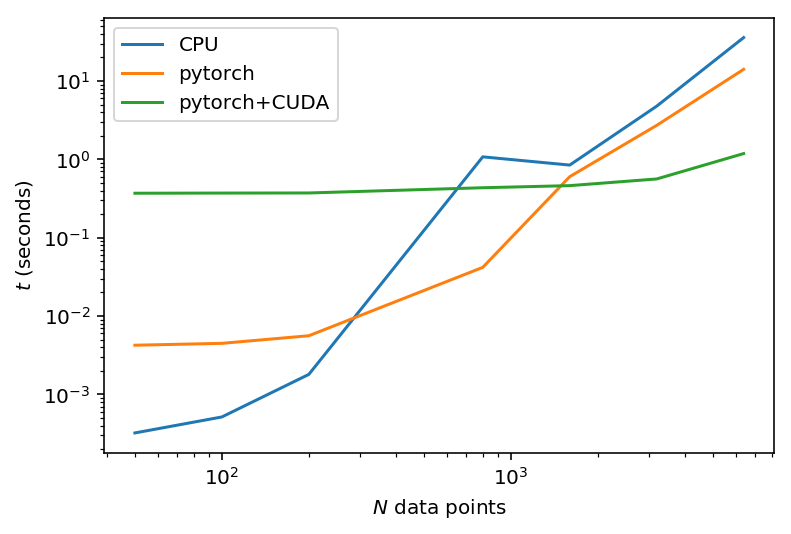

In [5]:
plt.plot(df['N samples'], df.CPU, label='CPU')
plt.plot(df['N samples'], df['pytorch'], label='pytorch')
plt.plot(df['N samples'], df['pytorch+gpu'], label='pytorch+CUDA')
plt.xlabel('$N$ data points')
plt.ylabel('$t$ (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.savefig('pytorch_LS_covariance_performance.png', dpi=300)

The end!  
-gully  
12:40 PM